# Lab 2: CIFAR10 图片分类

## 数据描述

在这个实验中，我们使用 `torchvision` 自带的 CIFAR10 数据集。CIFAR-10 中的图像尺寸为 3x32x32，即大小为 32x32 像素的 3 通道彩色图像。其中包含以下 10 个类别：“飞机”、“汽车”、“鸟”、“猫”、“鹿”、“狗”、“青蛙”、“马”、“船”、“卡车”。

我们将使用 CIFAR-10 数据集训练一个MLP网络，以对图像进行分类。

## 评估指标

在这个实验中，我们使用准确率作为评估指标，即分类正确的样本数占总样本数的比例：

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$$

## 要求

20 个 epoch 内，在训练集上的最优准确率达到 80% 以上，在测试集上的最优准确率达到 50% 以上。


## 数据下载和预处理

由于 CIFAR-10 自带了测试集，所以我们不需要手动划分训练集和测试集。我们可以直接使用 `torchvision.datasets.CIFAR10` 加载 CIFAR-10 数据集，并指定 `train=True` 来加载训练集，`train=False` 来加载测试集。

在加载数据集时，我们可以通过 `torchvision` 对 CIFAR-10 数据集一些预处理操作，例如将图像转换为张量、对图像进行标准化等。在这个实验中，我们将对 CIFAR-10 数据集进行如下预处理操作：

- `transforms.ToTensor()`:
  - 将 `numpy.ndarray` 格式的图像转换为 `torch.Tensor` 格式的张量
  - 将图像的像素强度值从 [0, 255] 缩放到 [0.0, 1.0]
  - 将图像的维度顺序从 `(H,W,C)` 转换为 `(C,H,W)`
- `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`:
  - 将图像的像素值从 [0.0, 1.0] 标准化到 [-1.0, 1.0]，即 (x - 0.5) / 0.5，使得数据的分布更接近标准正态分布，有助于模型的训练。


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(42)

# 将数据集转换为tensor，并归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 下载CIFAR10数据集
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

print("trainset size: ", len(trainset))
print("testset size: ", len(testset))

Files already downloaded and verified
Files already downloaded and verified
trainset size:  50000
testset size:  10000


接下来我们展示一下 CIFAR-10 数据集中的数据样本。


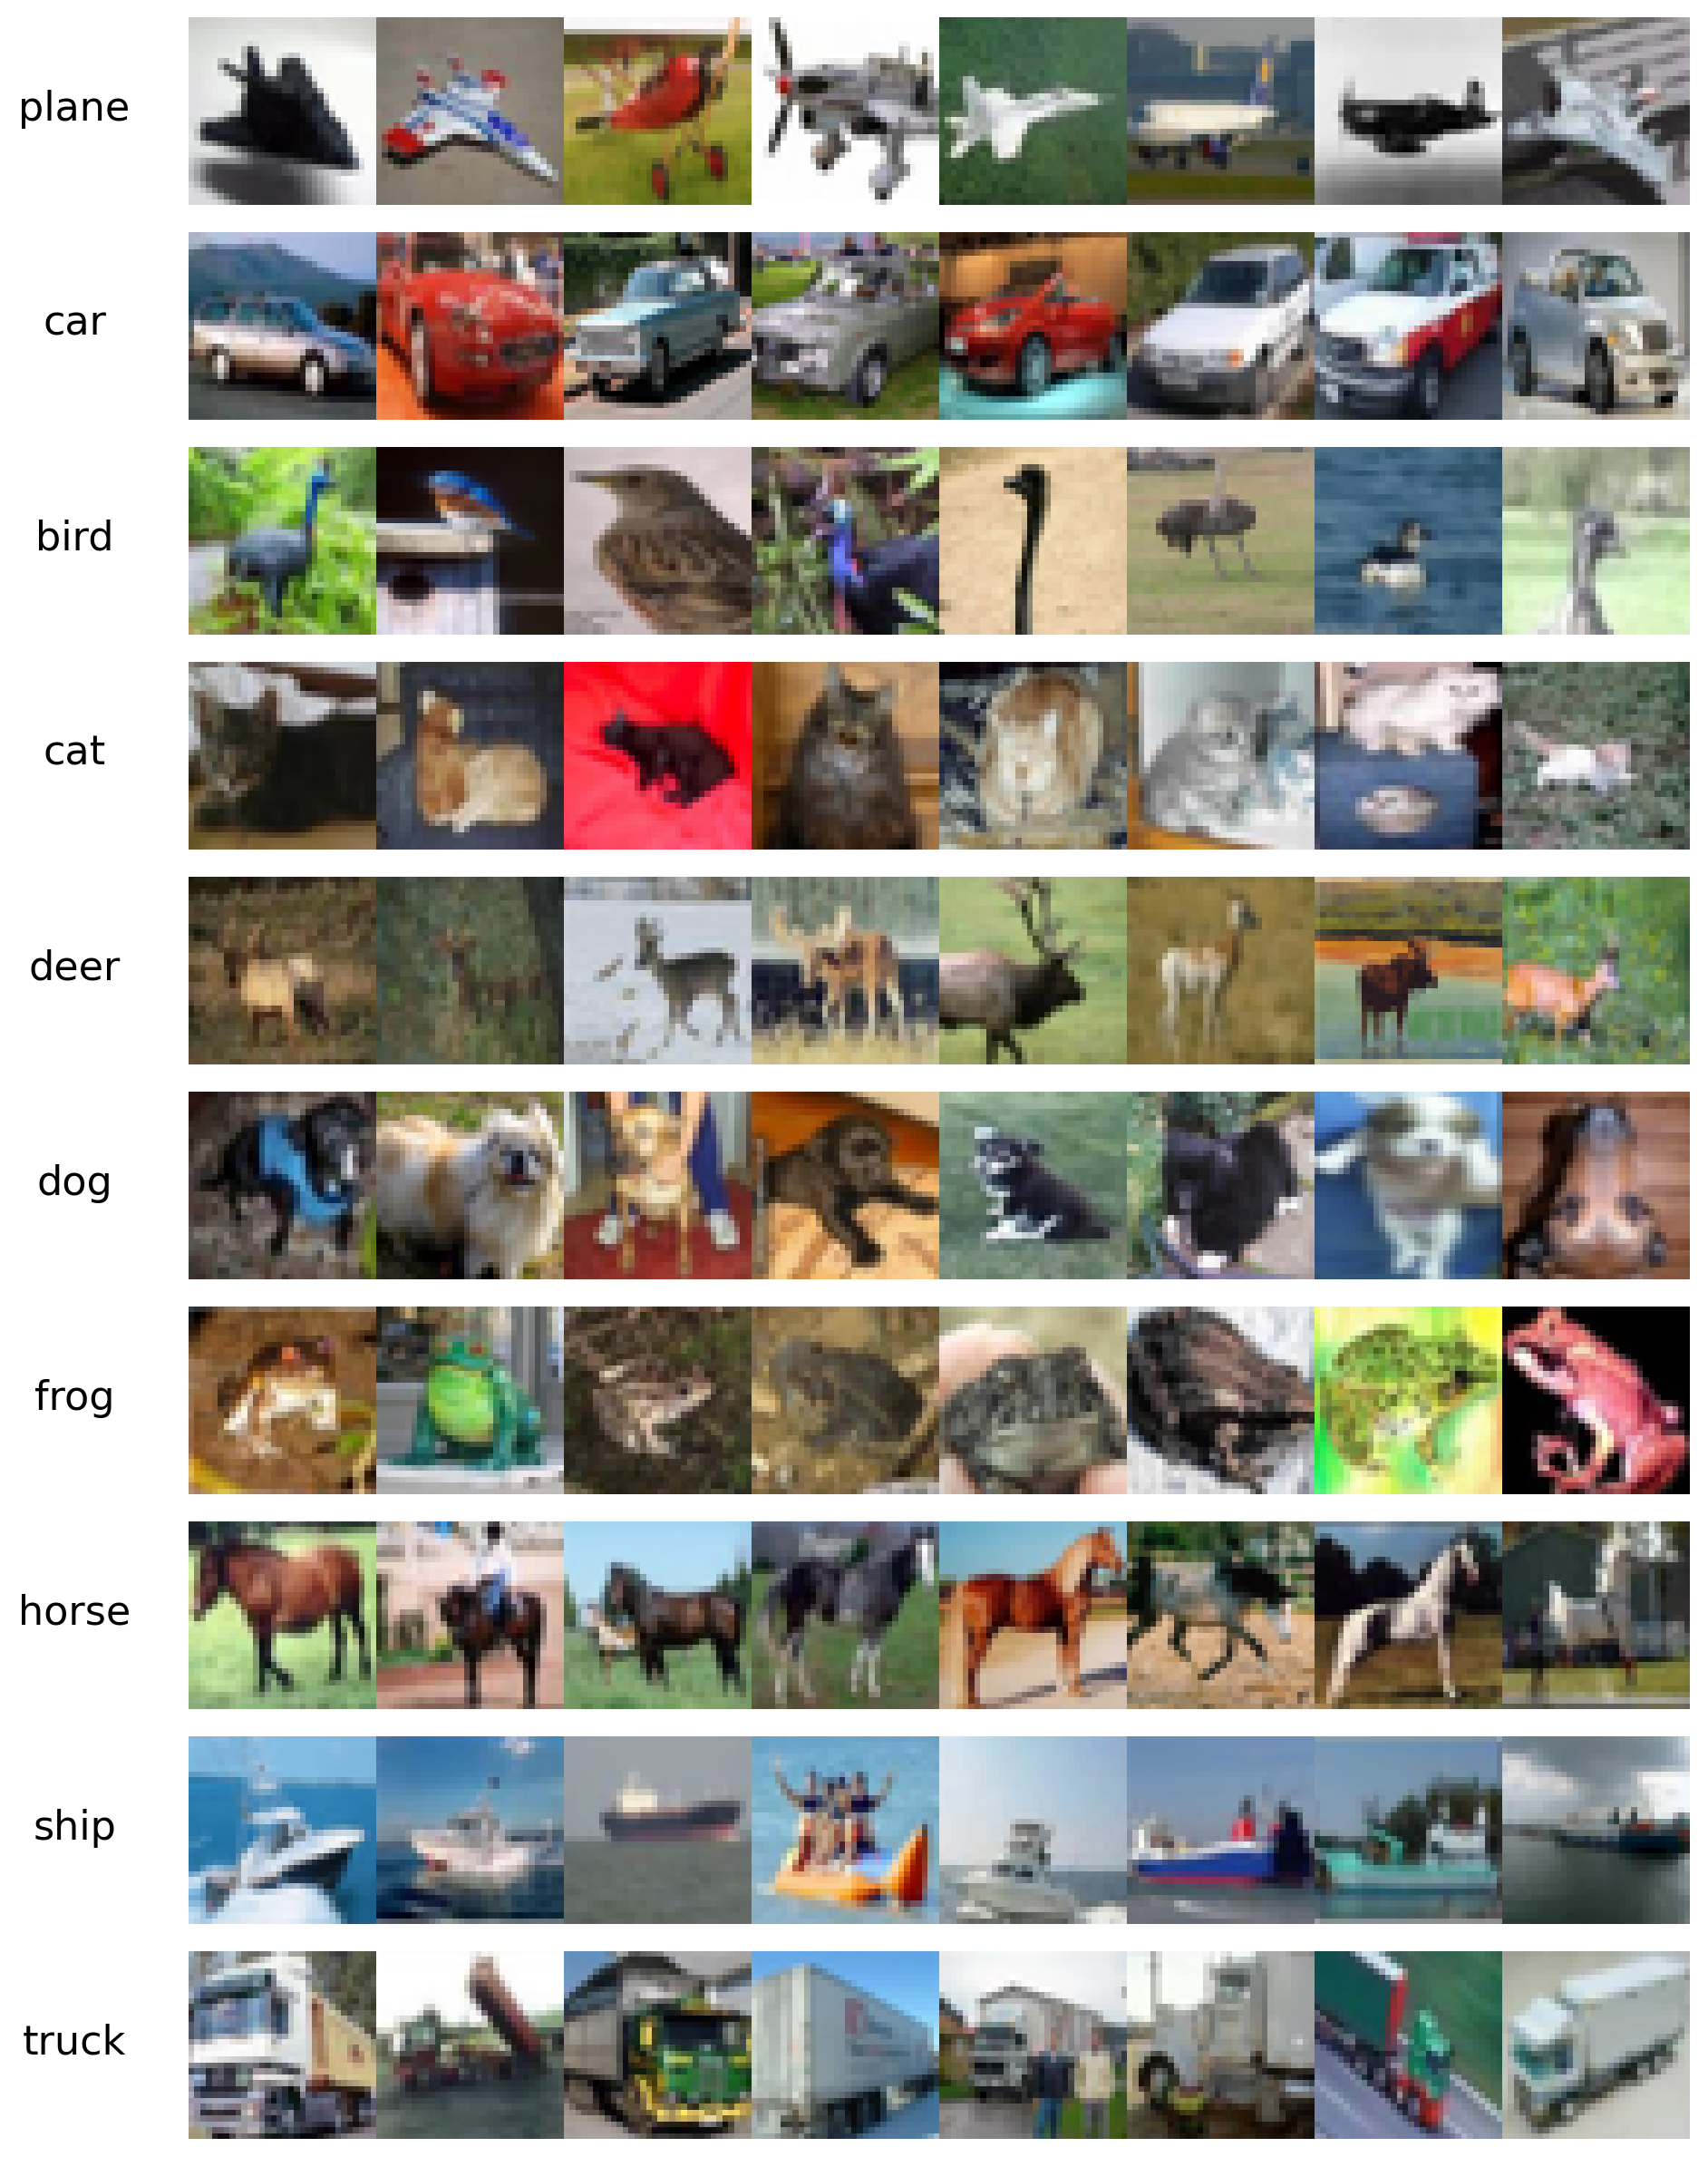

In [2]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

def show_images_by_class(dataset, num_images=8):
    classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
    class_images = {class_name: [] for class_name in classes}

    # 遍历数据集，为每个类别收集图像
    for image, label in dataset:
        class_name = classes[label]
        if len(class_images[class_name]) < num_images:
            class_images[class_name].append(image / 2 + 0.5)
        # 当每个类别都收集到足够的图像时，停止
        if all(len(images) == num_images for images in class_images.values()):
            break

    fig, axes = plt.subplots(len(classes), 1, figsize=(12, 12))
    for ax, (class_name, images) in zip(axes, class_images.items()):
        ax.axis("off")
        grid = make_grid(images, nrow=num_images, padding=0)
        ax.imshow(grid.permute(1, 2, 0))
        ax.text(-20, 15, class_name, fontsize=16, ha="center", va="center")
    plt.tight_layout()
    plt.show()


show_images_by_class(trainset)

然后依旧是用 `torch.utils.data.DataLoader`来加载数据集。


In [3]:
def load_data(batch_size=64):
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)
    return train_loader, test_loader


train_loader, test_loader = load_data()
X_batch, y_batch = next(iter(train_loader))
print("X_batch shape: ", X_batch.shape)
print("y_batch shape: ", y_batch.shape)

X_batch shape:  torch.Size([64, 3, 32, 32])
y_batch shape:  torch.Size([64])


## 构建 MLP 网络

输入数据的维度为 `(N, C, H, W) = (N, 3, 32, 32)`，其中 `N` 为 batch size，`C` 为通道数，`H` 和 `W` 分别为图像的高和宽。如果要使用MLP网络，需要先将输入数据展平为 `(N, 3*32*32)`，可以使用 `torch.flatten` 函数来实现。

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_size=32 * 32 * 3, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = MLP()
x_test = torch.randn(20, 3, 32, 32)
y_test = net(x_test)
assert y_test.shape == torch.Size([20, 10]), f"Expected output shape: [20, 10], but got: {y_test.shape}"

## 训练与测试

流程同 Lab1，但每训练完一次 epoch 后，我们需要额外评估模型的准确率。

In [26]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch(net, device, train_iter, loss_fn, optimizer):
    # 将模型设置为训练模式
    net.train()
    metrics = Accumulator(4)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        # 计算梯度并更新参数
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
    train_loss = metrics[0] / metrics[2]
    train_acc = metrics[1] / metrics[2]
    return train_loss, train_acc


@torch.no_grad()
def eval_model(net, device, test_iter, loss_fn):
    net.eval()
    metrics = Accumulator(3)
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
    test_loss = metrics[0] / metrics[2]
    test_acc = metrics[1] / metrics[2]
    return test_loss, test_acc


def accuracy(y_hat, y_true):
    y_pred = y_hat.argmax(dim=1)
    return (y_pred == y_true).float().mean().item()

In [31]:
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_iter, test_iter = load_data(batch_size=512)

train_ls, test_ls, train_acc_ls, test_acc_ls = [], [], [], []
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_epoch(model, device, train_iter, loss_fn, optimizer)
    test_loss, test_acc = eval_model(model, device, test_iter, loss_fn)
    print(
        f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f} - Train Acc: {train_acc:.6f} - Test Acc: {test_acc:.6f}"
    )
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)

Epoch 1/20 - Train Loss: 1.672218 - Test Loss: 1.522555 - Train Acc: 0.413940 - Test Acc: 0.467100
Epoch 2/20 - Train Loss: 1.452033 - Test Loss: 1.443354 - Train Acc: 0.495980 - Test Acc: 0.494700
Epoch 3/20 - Train Loss: 1.345095 - Test Loss: 1.392345 - Train Acc: 0.531680 - Test Acc: 0.514600
Epoch 4/20 - Train Loss: 1.263651 - Test Loss: 1.391478 - Train Acc: 0.562580 - Test Acc: 0.510900
Epoch 5/20 - Train Loss: 1.204297 - Test Loss: 1.379049 - Train Acc: 0.585180 - Test Acc: 0.519400
Epoch 6/20 - Train Loss: 1.140930 - Test Loss: 1.371887 - Train Acc: 0.607120 - Test Acc: 0.521800
Epoch 7/20 - Train Loss: 1.089996 - Test Loss: 1.403754 - Train Acc: 0.624640 - Test Acc: 0.517300
Epoch 8/20 - Train Loss: 1.024844 - Test Loss: 1.372372 - Train Acc: 0.647120 - Test Acc: 0.531900
Epoch 9/20 - Train Loss: 0.976601 - Test Loss: 1.405268 - Train Acc: 0.665400 - Test Acc: 0.529300
Epoch 10/20 - Train Loss: 0.945796 - Test Loss: 1.394403 - Train Acc: 0.673620 - Test Acc: 0.536100
Epoch 11/

画出模型在训练集和测试集上的 Loss 和 Acc 曲线。

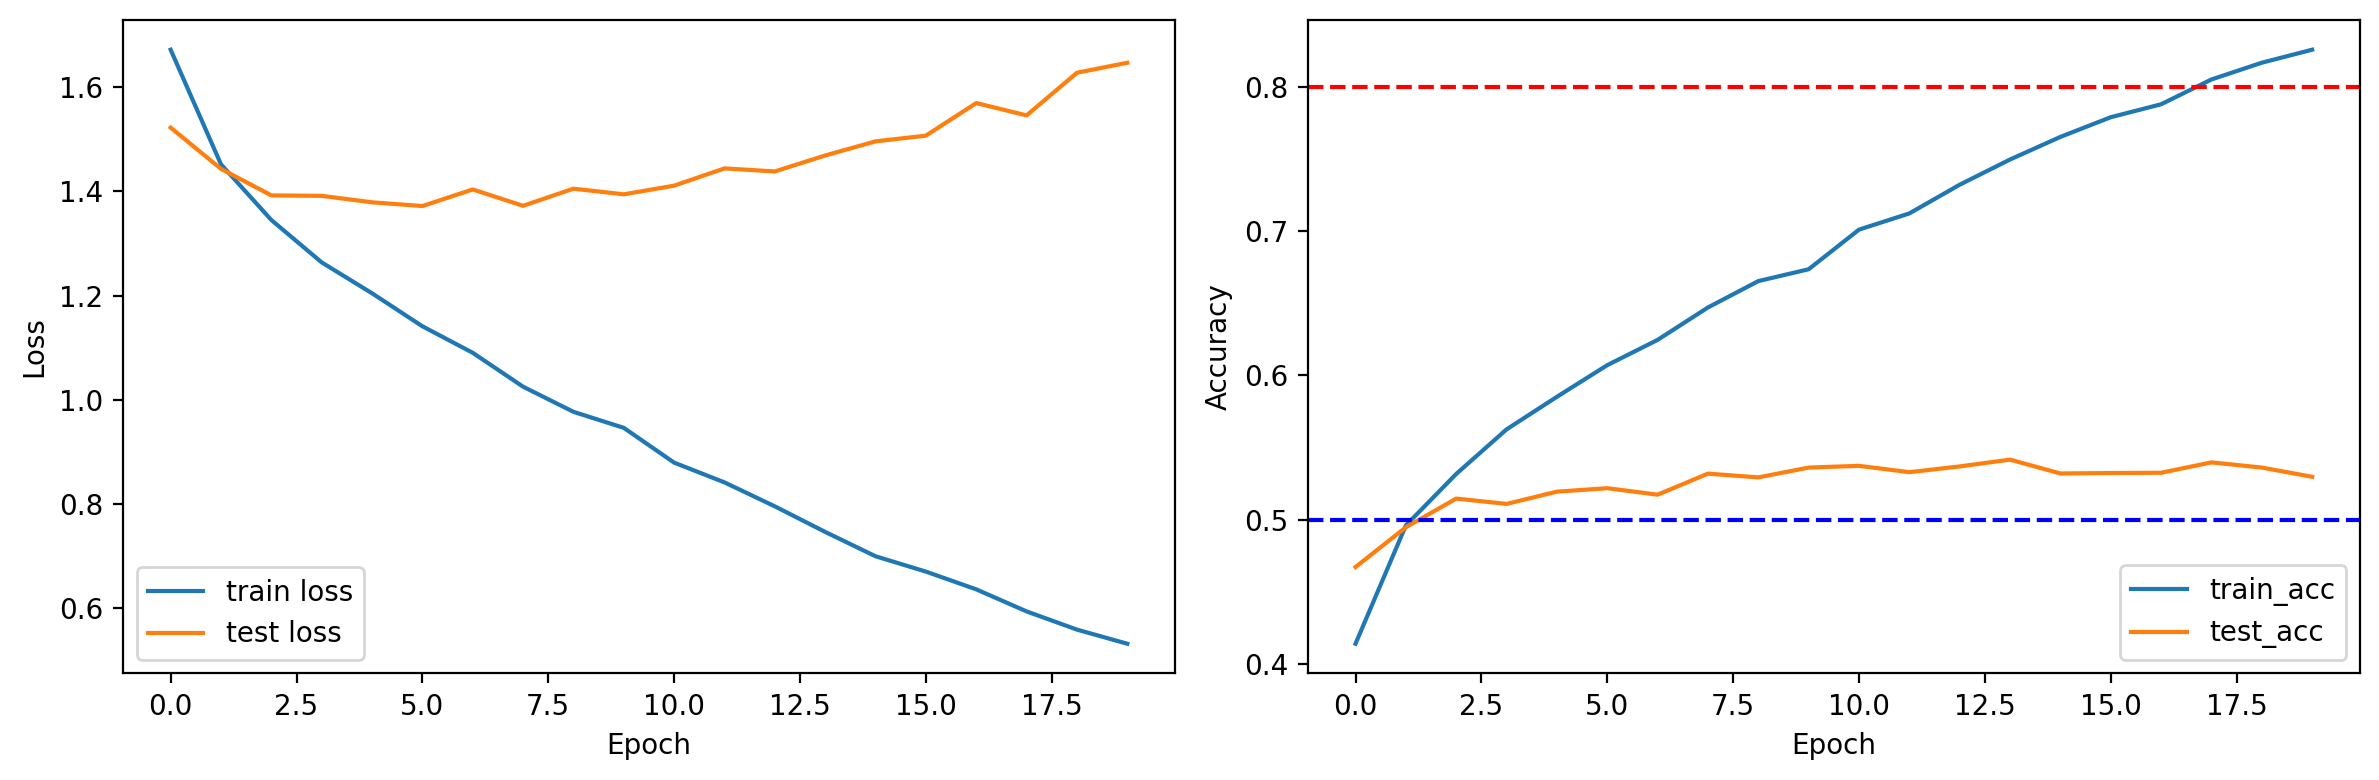

In [35]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 绘制第一个子图
axs[0].plot(train_ls, label="train loss")

axs[0].plot(test_ls, label="test loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# 绘制第二个子图
axs[1].plot(train_acc_ls, label="train_acc")
axs[1].plot(test_acc_ls, label="test_acc")
axs[1].axhline(y=0.8, color='r', linestyle='--')  # 添加 y=0.8 的参考线
axs[1].axhline(y=0.5, color='b', linestyle='--')  # 添加 y=0.5 的参考线
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [39]:
print("Best test accuaracy: ", max(test_acc_ls))
print("Best train accuaracy: ", max(train_acc_ls))

Best test accuaracy:  0.541599999332428
Best train accuaracy:  0.8258600002098083
